In [1]:
import pandas as pd
import numpy as np

input_file = "CICIDS2018_cleaned_noNaNs.csv"
output_file = "CICIDS2018_filtered_subset.csv"
chunk_size = 100_000

#Filter and relabel relevant attacks
attack_labels = [
    'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP',
    'DoS attacks-GoldenEye', 'DoS attacks-Hulk',
    'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris',
    'FTP-BruteForce', 'SSH-Bruteforce',
    'Brute Force -Web', 'Brute Force -XSS',
    'SQL Injection'
]

label_map = {
    "DDOS attack-HOIC": "DDoS",
    "DDOS attack-LOIC-UDP": "DDoS",
    "DoS attacks-Hulk": "DDoS",
    "DoS attacks-GoldenEye": "DDoS",
    "DoS attacks-Slowloris": "DDoS",
    "DoS attacks-SlowHTTPTest": "DDoS",
    "FTP-BruteForce": "Brute Force",
    "SSH-Bruteforce": "Brute Force",
    "Brute Force -Web": "Brute Force",
    "Brute Force -XSS": "Brute Force"
}

filtered_chunks = []

for chunk in pd.read_csv(input_file, chunksize=chunk_size, low_memory=False, on_bad_lines='skip'):
    if "Label" not in chunk.columns:
        continue

    chunk['Label'] = chunk['Label'].astype(str).str.strip()
    filtered_chunk = chunk[chunk['Label'].isin(attack_labels)].copy()

    if filtered_chunk.empty:
        continue

    # Label remap
    filtered_chunk['Label'] = filtered_chunk['Label'].replace(label_map)
    filtered_chunk['Label'] = filtered_chunk['Label'].astype('category')
    filtered_chunk['Label_cat'] = filtered_chunk['Label'].cat.codes

    filtered_chunks.append(filtered_chunk)

# Save final dataset
if filtered_chunks:
    df_filtered = pd.concat(filtered_chunks, ignore_index=True)
    df_filtered.to_csv(output_file, index=False)
    print(f"Filtered dataset saved to '{output_file}' — Total rows: {len(df_filtered)}")
else:
    print("No matching data found.")

Filtered dataset saved to 'CICIDS2018_filtered_subset.csv' — Total rows: 1723913


In [2]:
from collections import Counter

chunk_size = 100_000
label_counter = Counter()

for chunk in pd.read_csv("CICIDS2018_filtered_subset.csv", usecols=["Label"], chunksize=chunk_size):
    label_counter.update(chunk["Label"].dropna())

print("Label distribution:")
for label, count in label_counter.items():
    print(f"{label}: {count}")

Label distribution:
Brute Force: 381784
DDoS: 1342042
SQL Injection: 87


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


c:\Users\izzat\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9328 - loss: 0.1265 - val_accuracy: 0.9398 - val_loss: 0.1040
Epoch 2/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9427 - loss: 0.1041 - val_accuracy: 0.9466 - val_loss: 0.1012
Epoch 3/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9448 - loss: 0.1022 - val_accuracy: 0.9466 - val_loss: 0.1010
Epoch 4/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9453 - loss: 0.1018 - val_accuracy: 0.9466 - val_loss: 0.1030
Epoch 5/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9449 - loss: 0.1024 - val_accuracy: 0.9461 - val_loss: 0.1011
Epoch 6/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9455 - loss: 0.1015 - val_accuracy: 0.9466 - val_loss: 0.1004
Epoch 7/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9457 - loss: 0.1018 - val_accuracy: 0.9463 - val_loss: 0.1004
Epoch 8/10
4310/4310 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9455 - loss: 0

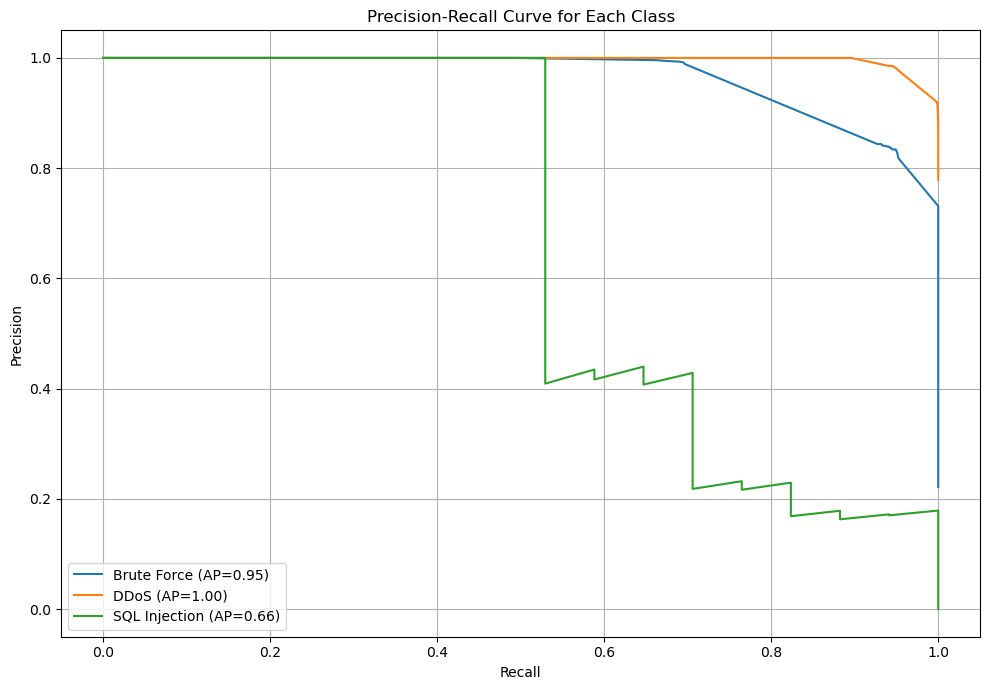

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("CICIDS2018_filtered_subset.csv")
df = df[df['Label'] != 'BENIGN']

# Drop unnecessary columns
drop_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Src Port']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Convert all non-label columns to numeric
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(inplace=True)

# Feature engineering
df['burstiness_score'] = (df['Pkt Len Max'] - df['Pkt Len Min']) / (df['Pkt Len Mean'] + 1e-5)
df['flow_duration_norm'] = df['Flow Duration'] / (df['Tot Fwd Pkts'] + df['Tot Bwd Pkts'] + 1e-5)
df['packet_symmetry'] = abs(df['Tot Fwd Pkts'] - df['Tot Bwd Pkts']) / (df['Tot Fwd Pkts'] + df['Tot Bwd Pkts'] + 1e-5)
df['avg_packet_size'] = df['TotLen Fwd Pkts'] / (df['Tot Fwd Pkts'] + 1e-5)
df['packet_rate'] = df['Tot Fwd Pkts'] / (df['Flow Duration'] / 1e6 + 1e-5)
df['flow_rate'] = df['TotLen Fwd Pkts'] / (df['Flow Duration'] / 1e6 + 1e-5)

df['Label'] = df['Label'].astype('category')
df['Label_cat'] = df['Label'].cat.codes

X = df.drop(columns=['Label', 'Label_cat'])
y = df['Label_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build DNN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train_cat, epochs=10, batch_size=256, validation_split=0.2)

# Predict and plot PR curve
y_pred_probs = model.predict(X_test_scaled)
class_names = df['Label'].cat.categories.tolist()
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_cat[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_test_cat[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

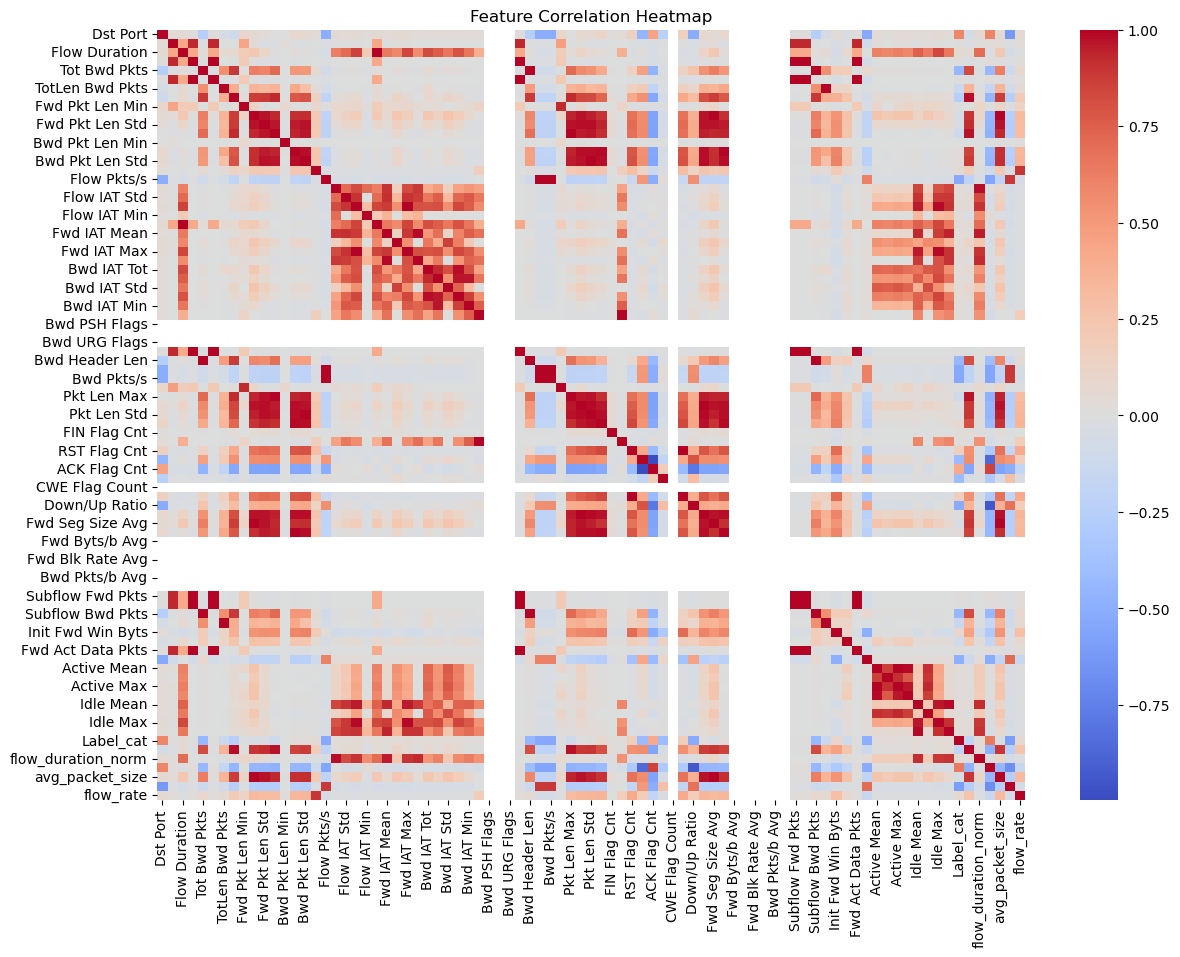

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap of top correlated features
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#Generator
def build_generator(latent_dim, num_classes, output_dim):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label_input))
    
    merged_input = Concatenate()([noise_input, label_embedding])
    x = GaussianNoise(0.1)(merged_input)
    
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    output = Dense(output_dim)(x) 
    
    return Model([noise_input, label_input], output)

#Discriminator
def build_discriminator(input_dim, num_classes):
    data_input = Input(shape=(input_dim,))
    label_input = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, input_dim)(label_input))
    
    merged_input = Concatenate()([data_input, label_embedding])
    
    x = Dense(256)(merged_input)
    x = LeakyReLU(0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model([data_input, label_input], x)

#Combined CGAN
def build_cgan(generator, discriminator, latent_dim):
    discriminator.trainable = False
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(1,), dtype='int32')
    gen_data = generator([noise_input, label_input])
    valid = discriminator([gen_data, label_input])
    return Model([noise_input, label_input], valid)

#Training Function
def train_conditional_cgan(X_train, y_train, latent_dim=100, num_classes=3, epochs=10000, batch_size=32):
    input_dim = X_train.shape[1]
    generator = build_generator(latent_dim, num_classes, input_dim)
    discriminator = build_discriminator(input_dim, num_classes)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    cgan = build_cgan(generator, discriminator, latent_dim)
    cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    for epoch in range(epochs):
        # Real samples
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        real_labels = y_train[idx]

        # Fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        gen_data = generator.predict([noise, gen_labels], verbose=0)

        valid = np.ones((batch_size, 1)) * 0.9 
        fake = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_data, real_labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_data, gen_labels], fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        valid_y = np.ones((batch_size, 1))

        g_loss = cgan.train_on_batch([noise, sampled_labels], valid_y)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

    return generator, discriminator, cgan

In [7]:
generator, discriminator, cgan = train_conditional_cgan(
    X_train_scaled, y_train.to_numpy().reshape(-1, 1),
    latent_dim=100,
    num_classes=3,
    epochs=10000,
    batch_size=64
)

c:\Users\izzat\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6299] [G loss: 0.5075]
1000 [D loss: 3.3105] [G loss: 0.0215]
2000 [D loss: 4.1405] [G loss: 0.0109]
3000 [D loss: 4.6010] [G loss: 0.0073]
4000 [D loss: 4.9296] [G loss: 0.0055]
5000 [D loss: 5.1930] [G loss: 0.0044]
6000 [D loss: 5.4192] [G loss: 0.0037]
7000 [D loss: 5.6225] [G loss: 0.0031]
8000 [D loss: 5.8094] [G loss: 0.0028]
9000 [D loss: 5.9861] [G loss: 0.0024]


In [8]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

#Generate synthetic SQL Injection sample
latent_dim = 100
target_class = 2
n_synthetic = 2000 

noise = np.random.normal(0, 1, (n_synthetic, latent_dim))
labels_sql = np.full((n_synthetic, 1), target_class, dtype='int32')
labels_tf = tf.convert_to_tensor(labels_sql, dtype=tf.int32)

synthetic_sql = generator.predict([noise, labels_tf], verbose=0)

#Combine with real training data
X_combined = np.vstack([X_train_scaled, synthetic_sql])
y_combined = np.hstack([y_train.to_numpy().flatten(), np.full(n_synthetic, target_class)])

#Re-scale combined data
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined)

#Final train-test split (replaces Step 7!)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_combined_scaled, y_combined,
    test_size=0.2,
    stratify=y_combined,
    random_state=42
)

#One-hot encode labels
y_train_final_cat = to_categorical(y_train_final, num_classes=3)
y_test_final_cat = to_categorical(y_test_final, num_classes=3)

print("Final train/test split complete.")
print("Train class distribution:", np.bincount(y_train_final.astype(int)))
print("Test class distribution:", np.bincount(y_test_final.astype(int)))

Final train/test split complete.
Train class distribution: [244342 858906   1656]
Test class distribution: [ 61085 214727    414]


In [9]:
import joblib
joblib.dump(scaler_combined, "scaler.save")

['scaler.save']

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_flat = y_train_final.astype(int)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)
class_weights = dict(enumerate(class_weights_array))
class_weights[1] *= 1.2

print("Class weights (adjusted):", class_weights)

Class weights (adjusted): {0: 1.5073189764073853, 1: 0.5145634097328462, 2: 222.40418679549114}


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#Model configuration
epochs = 50
batch_size = 64
learning_rate = 0.0005 

#Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

#Define the improved model
model = Sequential([
    Dense(512, input_shape=(X_train_final.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4), BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(3, activation='softmax')  # 3 classes: Brute Force, DDoS, SQLi
])

#Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model using correctly prepared data
history = model.fit(
    X_train_final, y_train_final_cat,
    validation_data=(X_test_final, y_test_final_cat),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

c:\Users\izzat\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17265/17265 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.9056 - loss: 1.0591 - val_accuracy: 0.9194 - val_loss: 0.4253 - learning_rate: 5.0000e-04
Epoch 2/50
17265/17265 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.9144 - loss: 0.4640 - val_accuracy: 0.9197 - val_loss: 0.2088 - learning_rate: 5.0000e-04
Epoch 3/50
17265/17265 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - accuracy: 0.9142 - loss: 0.3096 - val_accuracy: 0.9196 - val_loss: 0.2483 - learning_rate: 5.0000e-04
Epoch 4/50
17259/17265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9182 - loss: 0.2206
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
17265/17265 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9181 - loss: 0.2206 - val_accuracy: 0.9194 - val_loss: 0.2940 - learning_rate: 5.0000e-04
Epoch 5/50
17265/17265 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.9200 - loss: 0.2275 - val_accuracy: 0.9395 - val_loss: 0.1722 - learning_rate: 2.5000e-04
Epoch 6/50
17265/17265 ━━━━━━━━━━━━━━━━━

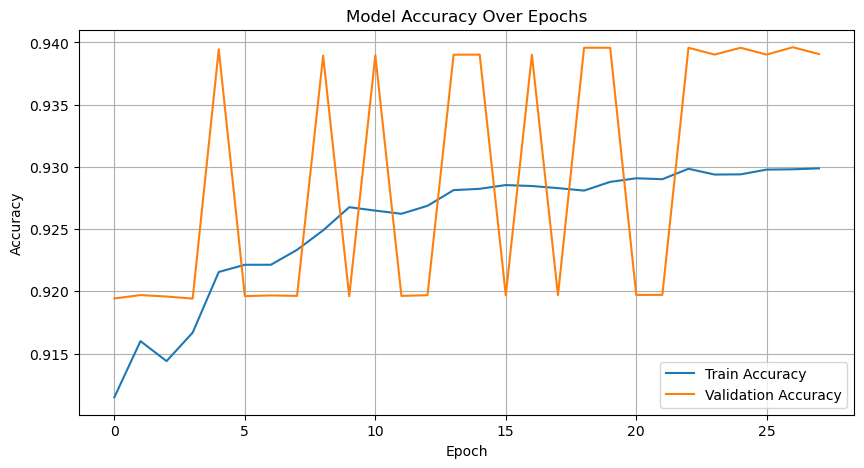

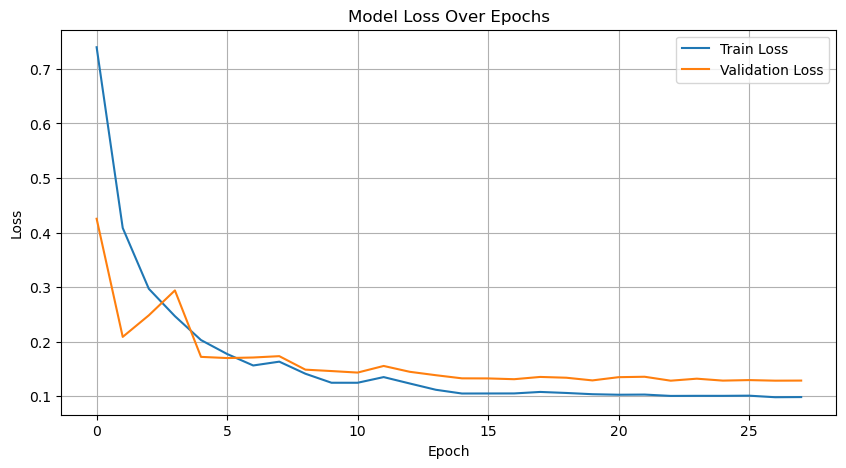

In [15]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

8633/8633 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


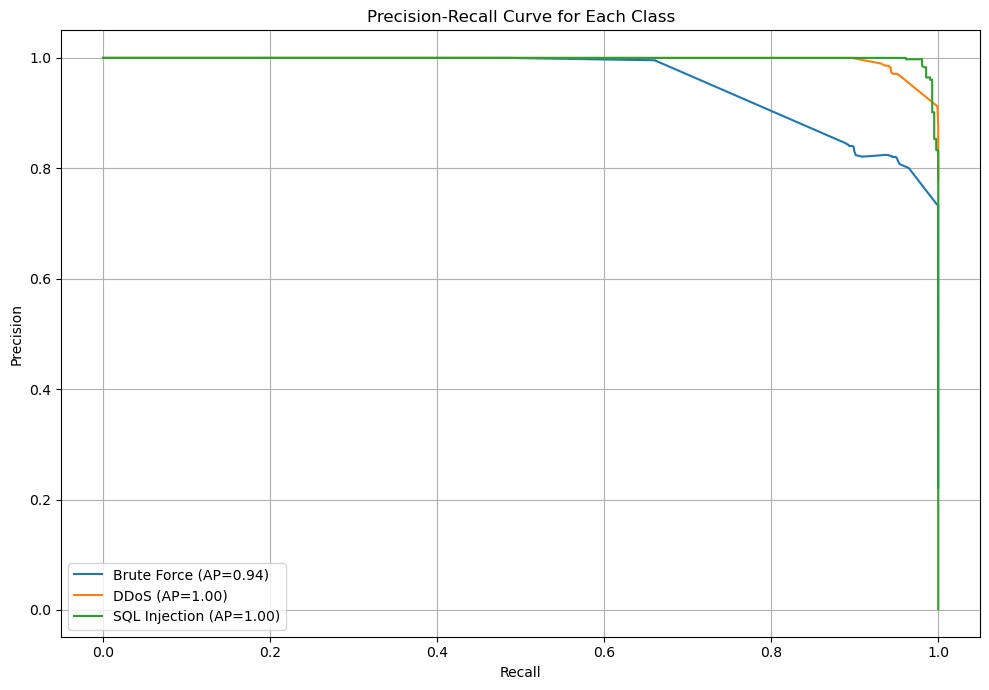

Classification Report (Per-Class Thresholding):

               precision    recall  f1-score   support

  Brute Force       0.81      0.95      0.87     61085
         DDoS       0.99      0.94      0.96    214727
SQL Injection       0.83      1.00      0.91       414

     accuracy                           0.94    276226
    macro avg       0.88      0.96      0.91    276226
 weighted avg       0.95      0.94      0.94    276226



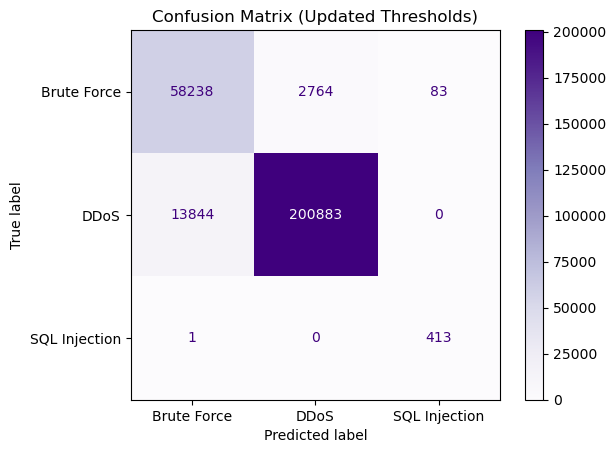

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict Probabilities
y_pred_probs = model.predict(X_test_final, verbose=1)

# Step 2: Precision-Recall Curves
class_names = ["Brute Force", "DDoS", "SQL Injection"]

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, thresholds = precision_recall_curve(y_test_final_cat[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_test_final_cat[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Per-Class Thresholding
thresholds = {0: 0.55, 1: 0.5, 2: 0.35}  # Brute Force, DDoS, SQL Injection

# Apply thresholding
y_pred_thresh = []
for probs in y_pred_probs:
    if probs[2] >= thresholds[2]:
        y_pred_thresh.append(2)
    elif probs[1] >= thresholds[1]:
        y_pred_thresh.append(1)
    elif probs[0] >= thresholds[0]:
        y_pred_thresh.append(0)
    else:
        y_pred_thresh.append(np.argmax(probs))  # fallback to argmax

# New line: Convert true labels back from one-hot to integer
y_true = np.argmax(y_test_final_cat, axis=1)

# Classification report
print("Classification Report (Per-Class Thresholding):\n")
print(classification_report(y_true, y_pred_thresh, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix (Updated Thresholds)")
plt.show()

In [17]:
model.save("best_dnn_model.keras")

In [18]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [19]:
import shap
import numpy as np
import pandas as pd

# Background dataset for SHAP (100 random training samples)
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Sample data to explain (e.g., 1000 samples)
X_shap_sample = pd.DataFrame(X_train_scaled[:1000], columns=X.columns)

# Create SHAP explainer for a probability output model
explainer = shap.Explainer(
    model, 
    background, 
    output_names=['Brute Force', 'DDoS', 'SQL Injection'], 
    model_output="probability"
)

In [20]:
shap_values = explainer(X_shap_sample)

PermutationExplainer explainer: 1001it [04:40,  3.47it/s]                          


In [21]:
print("SHAP shape:", shap_values.shape)

SHAP shape: (1000, 84, 3)



--- SHAP Summary for Brute Force ---


C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\3870234386.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, plot_type='bar', show=True)


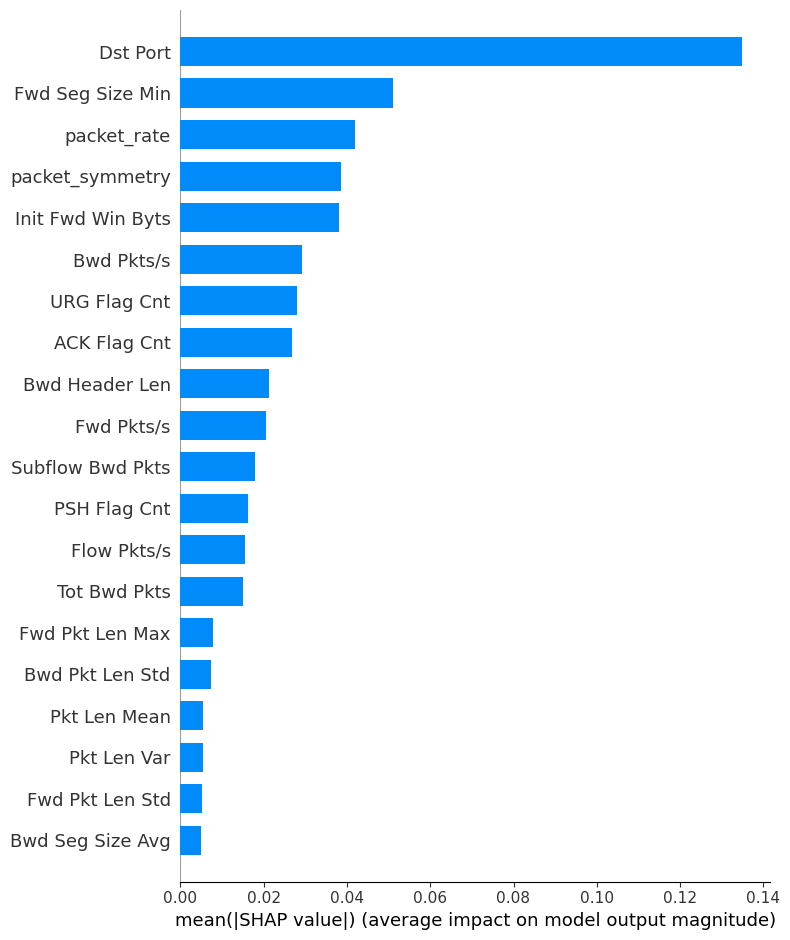


--- SHAP Summary for DDoS ---


C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\3870234386.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, plot_type='bar', show=True)


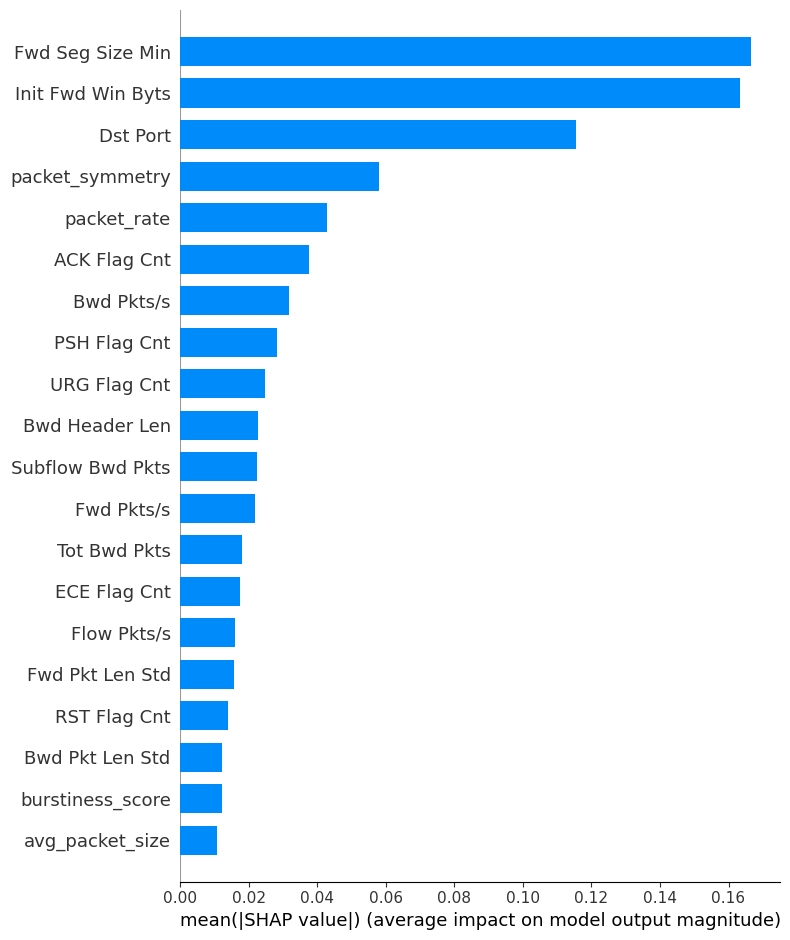


--- SHAP Summary for SQL Injection ---


C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\3870234386.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, plot_type='bar', show=True)


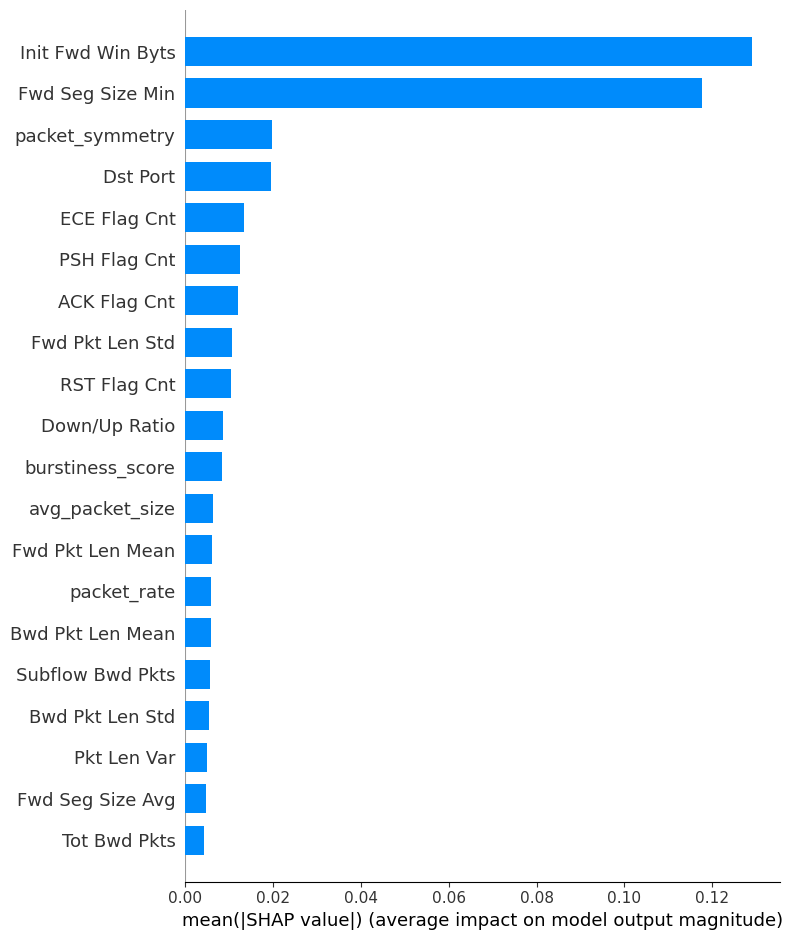

In [22]:
for i, class_name in enumerate(['Brute Force', 'DDoS', 'SQL Injection']):
    print(f"\n--- SHAP Summary for {class_name} ---")
    shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, plot_type='bar', show=True)

C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\2444460847.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], X_shap_sample)


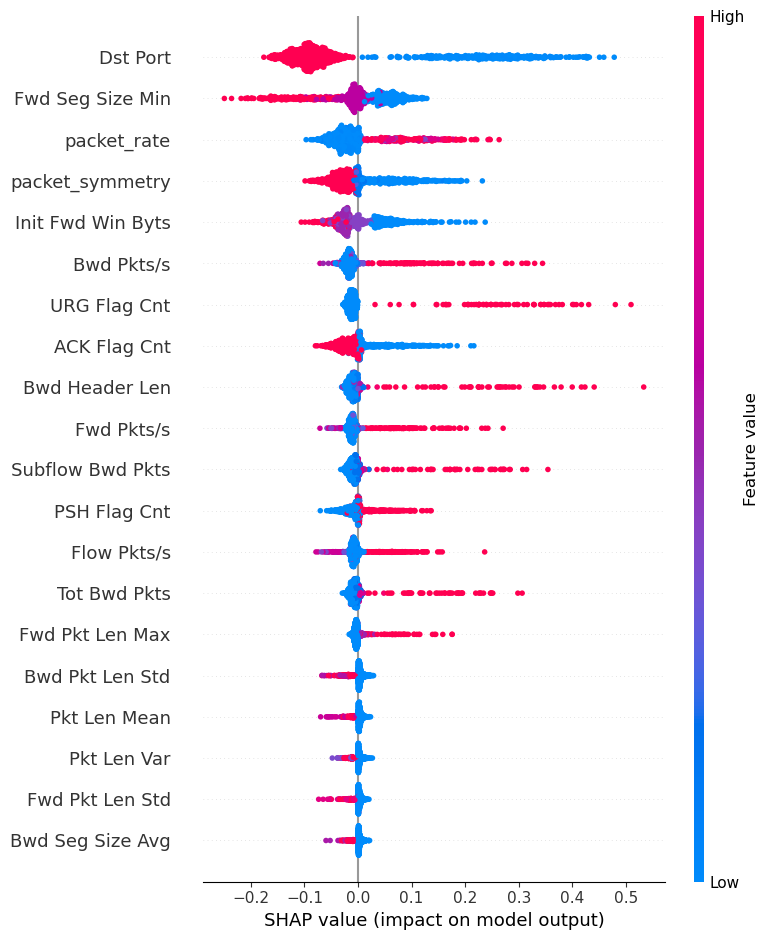

C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\2444460847.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 1], X_shap_sample)


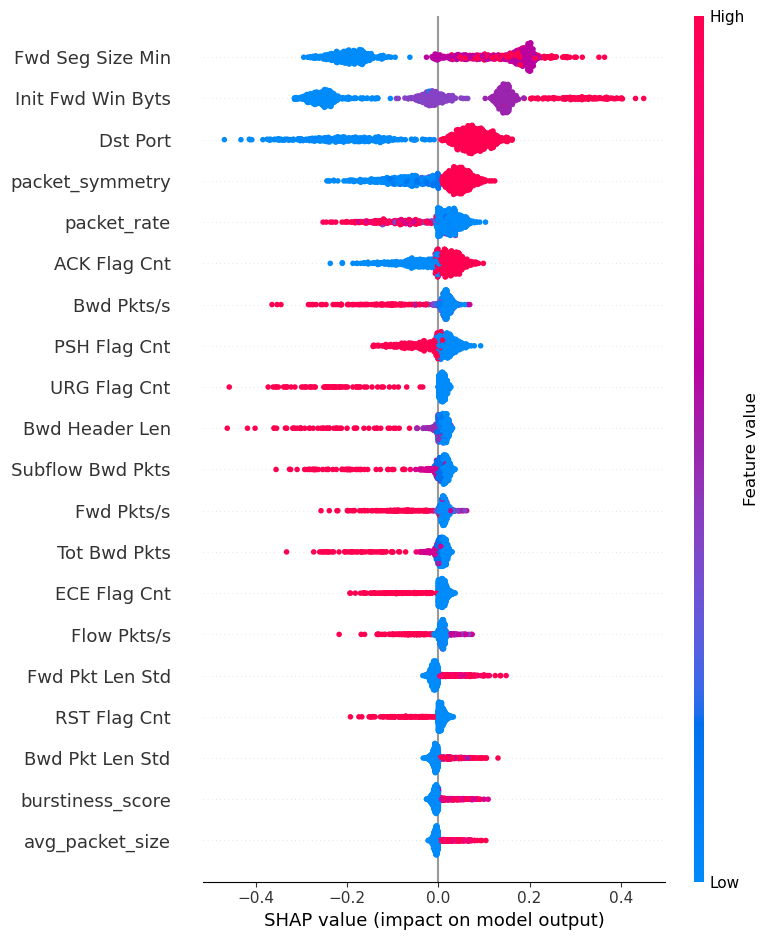

C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\2444460847.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 2], X_shap_sample)


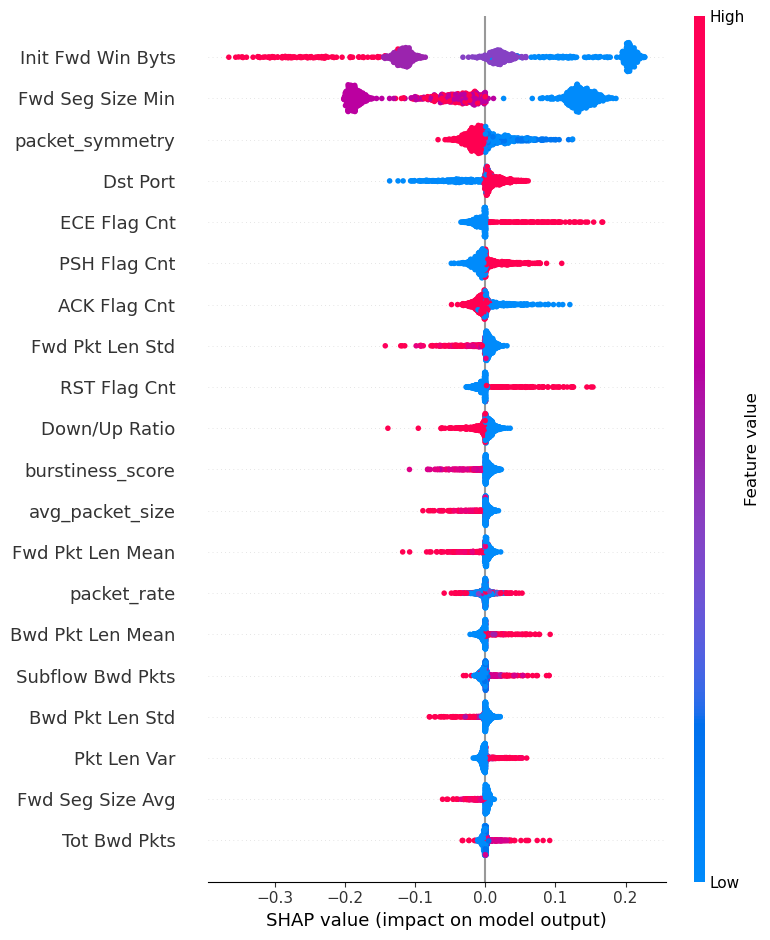

In [23]:
# For Brute Force (class 0)
shap.summary_plot(shap_values.values[:, :, 0], X_shap_sample)

# For DDoS (class 1)
shap.summary_plot(shap_values.values[:, :, 1], X_shap_sample)

# For SQL Injection (class 2)
shap.summary_plot(shap_values.values[:, :, 2], X_shap_sample)

In [24]:
sample_index = 0 

In [25]:
sample_index = 1

In [26]:
sample_index = 2

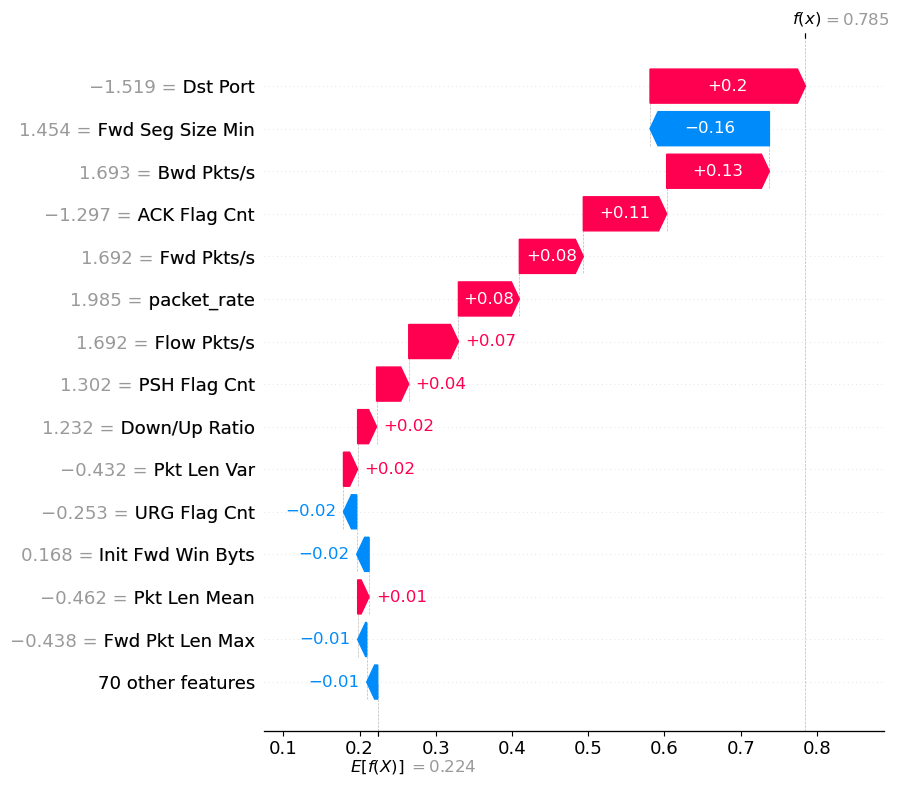

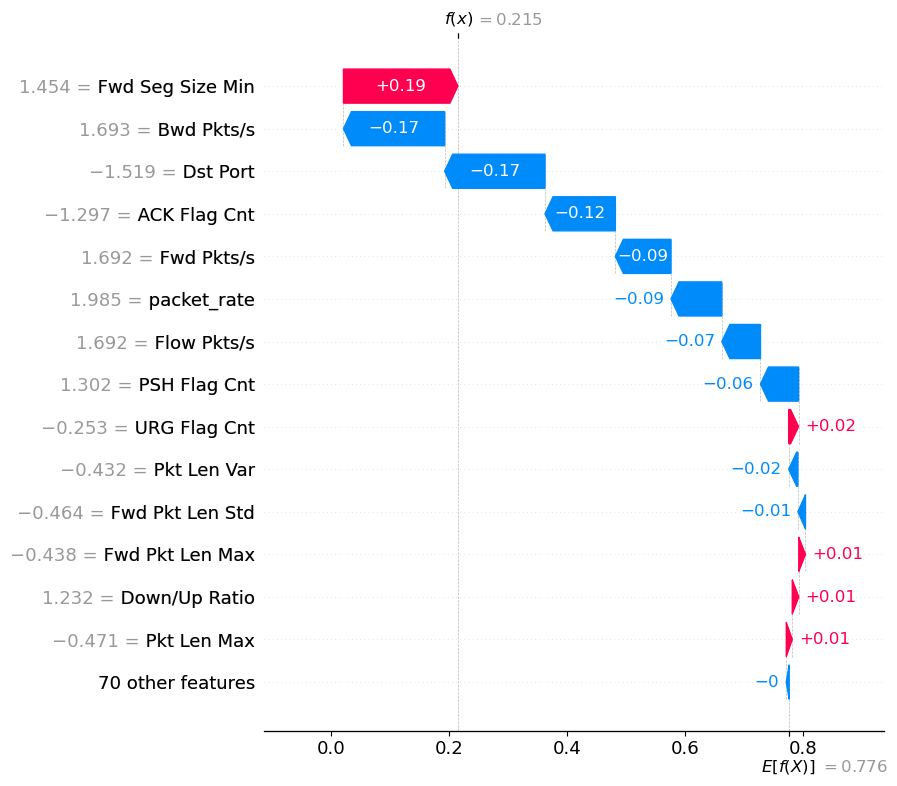

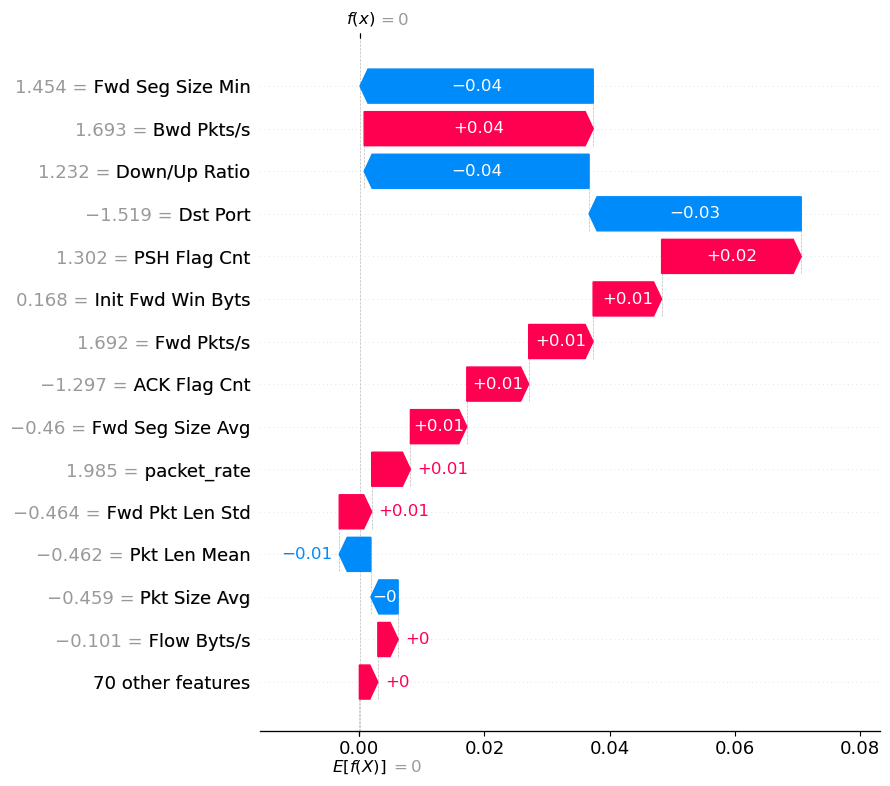

In [27]:
# Waterfall for Brute Force (class 0)
shap.plots.waterfall(shap_values[sample_index, :, 0], max_display=15)

# Waterfall for DDoS (class 1)
shap.plots.waterfall(shap_values[sample_index, :, 1], max_display=15)

# Waterfall for SQL Injection (class 2)
shap.plots.waterfall(shap_values[sample_index, :, 2], max_display=15)

In [33]:
import matplotlib.pyplot as plt

# Sample index to use
sample_index = 0

# Class labels
class_labels = ['Brute Force', 'DDoS', 'SQL Injection']

# Loop through each class
for i, label in enumerate(class_labels):
    shap.plots.waterfall(shap_values[sample_index, :, i], max_display=15, show=False)
    plt.title(f"SHAP Waterfall - {label}")
    plt.tight_layout()
    plt.savefig(f"waterfall_{label.replace(' ', '_')}_sample{sample_index}.png", dpi=300)
    plt.clf()

In [34]:
# SHAP Beeswarm (global feature impact)
for i, label in enumerate(class_labels):
    shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, show=False)
    plt.title(f"SHAP Beeswarm - {label}")
    plt.tight_layout()
    plt.savefig(f"beeswarm_{label.replace(' ', '_')}.png", dpi=300)
    plt.clf()

C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\3111357640.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, show=False)
C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\3111357640.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X_shap_sample, show=False)
C:\Users\izzat\AppData\Local\Temp\ipykernel_65560\3111357640.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour a